In [ ]:
# initialize accelerator and trackers (if enabled)
from os import makedirs, path, scandir
import pickle
import cv2
import json
from yacs.config import CfgNode as CN
from torch.utils.data import Dataset
from tqdm import tqdm
import logging
import random
import torch
# from src.datasets import FFPP,RPPG
from accelerate import Accelerator
from main import get_config, init_accelerator, set_seed, FFPP
logging.basicConfig(level="DEBUG")


class Obj:
    pass


c = FFPP.get_default_config()
c.augmentation = "normal+frame"
c.pair = 1
# c.contrast = 1
c.compressions = ["c23"]
# c.types = ["REAL", "DF", "FS", "F2F"]
accelerator = Accelerator(mixed_precision='no')
x = FFPP(c, 20, 5, lambda x: x, accelerator, split="train")
c

In [ ]:
typ, cmp, idx, _ = x.video_list[0]
x.video_table[typ][cmp][idx]

In [ ]:
a = x.get_dict(7079, True)

In [ ]:
len(x)

In [42]:
frames, label, mask, _, _ = x[random.randint(0, len(x))]
(len(frames), label, len(mask))

DEBUG:root:Item/Video Index:10446/3509
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 0.5917319823864347
DEBUG:root:Video Shift Factor: 0.16545545901500186
DEBUG:root:Loading Video: ./datasets/ffpp/NT/raw/videos/200_189.avi
DEBUG:root:Sample Offset: 10
DEBUG:root:Sample Stride: 0.15157894736842104
DEBUG:root:Video: ./datasets/ffpp/NT/raw/videos/200_189.avi, Completed!
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/200_189.avi
DEBUG:root:Sample Offset: 10
DEBUG:root:Sample Stride: 0.15157894736842104
DEBUG:root:Video: ./datasets/ffpp/NT/c23/videos/200_189.avi, Completed!


(2, 1, 20)

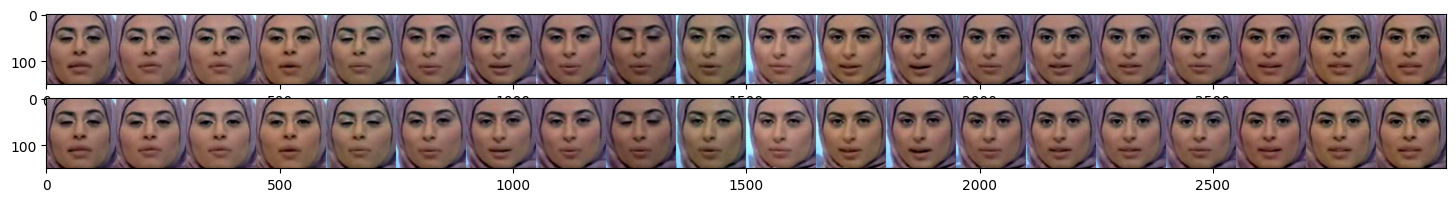

In [43]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 2))
plt.subplot(2, 1, 1)
plt.imshow(
    np.stack(
        frames["raw"][:30].numpy().transpose((0, 2, 3, 1)), axis=1
    ).reshape((150, -1, 3))
)
plt.subplot(2, 1, 2)
plt.imshow(
    np.stack(
        frames["c23"][:30].numpy().transpose((0, 2, 3, 1)), axis=1
    ).reshape((150, -1, 3))
)

In [ ]:
# for i in tqdm(range(len(x))):
#     try:
#         x[i]
#     except Exception as e:
#         print(f"Error Occur at {i}:{e}")